In [4]:
from to_vector import RiskDataProcessor
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

import datetime

/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# 配置路径
DATA_DIR = "/Users/mac/Desktop/risk-management/filtered_companys_adjusted"
# 初始化处理器
processor = RiskDataProcessor()
    
# 加载数据集
df = processor.create_dataset()
    
# 提取特征和标签
y = processor.process_labels(df["工商信息->工商信息->天眼评分"])
X = df.drop("工商信息->工商信息->天眼评分", axis=1)
    
# 执行特征转换
X_transformed = processor.get_feature_pipeline().fit_transform(X)
X = X_transformed.toarray()
y = np.array(y.values)

print("特征矩阵形状:", X.shape)
print("特征矩阵类型:", type(X))

print("标签形状:", y.shape)
print("标签类型:", type(y))
print(y[:10])

Loading Data: 100%|██████████| 109/109 [00:00<00:00, 2563.97it/s]

特征矩阵形状: (109, 517)
特征矩阵类型: <class 'numpy.ndarray'>
标签形状: (109,)
标签类型: <class 'numpy.ndarray'>
['B' 'A' 'C' 'B' 'D' 'A' 'B' 'A' 'A' 'B']


训练集大小: 76
测试集大小: 33
[0]	train-merror:0.07895	train-mlogloss:1.23813	val-merror:0.18182	val-mlogloss:1.24904
[10]	train-merror:0.02632	train-mlogloss:0.47073	val-merror:0.03030	val-mlogloss:0.52020
[20]	train-merror:0.02632	train-mlogloss:0.22784	val-merror:0.03030	val-mlogloss:0.29789
[30]	train-merror:0.02632	train-mlogloss:0.13464	val-merror:0.03030	val-mlogloss:0.22613
[40]	train-merror:0.02632	train-mlogloss:0.08868	val-merror:0.03030	val-mlogloss:0.19713
[50]	train-merror:0.00000	train-mlogloss:0.06841	val-merror:0.03030	val-mlogloss:0.19192
[60]	train-merror:0.00000	train-mlogloss:0.05760	val-merror:0.03030	val-mlogloss:0.19588
[68]	train-merror:0.00000	train-mlogloss:0.05369	val-merror:0.03030	val-mlogloss:0.19555

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         9
           B       1.00      1.00      1.00        18
           C       0.83      1.00      0.91         5
           D       0.00     

/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

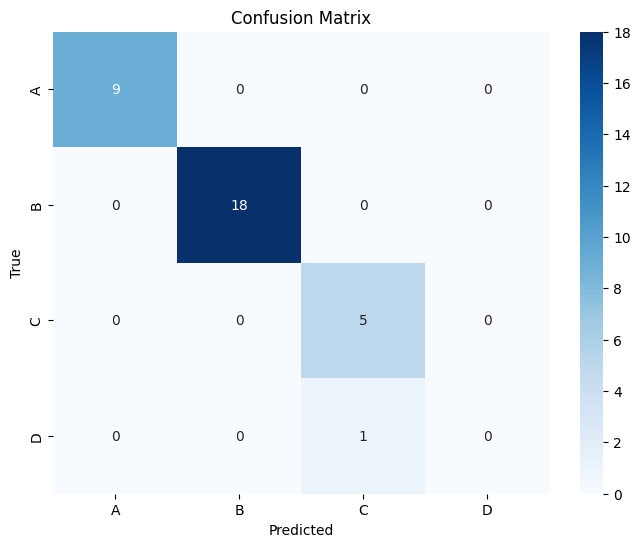

训练完成！模型已保存为 xgboost_cpu_model.json


In [13]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
import datetime
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------
# 标签编码（显式映射）
# ---------------------------------------------------
# 创建可解释的标签映射
label_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
reverse_mapping = {v: k for k, v in label_mapping.items()}

# 转换标签
y_encoded = np.array([label_mapping[label] for label in y])

# 验证标签完整性
unique_labels = np.unique(y)
assert set(unique_labels).issubset(label_mapping.keys()), f"发现未定义标签: {set(unique_labels) - set(label_mapping.keys())}"

# ---------------------------------------------------
# 数据划分
# ---------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y_encoded,
    test_size=0.3,
    random_state=42
)
print(f"训练集大小: {len(X_train)}")
print(f"测试集大小: {len(X_test)}")

# ---------------------------------------------------
# TensorBoard 日志配置
# ---------------------------------------------------
log_dir = f"logs/xgboost/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
writer = SummaryWriter(log_dir)

# ---------------------------------------------------
# XGBoost 配置（CPU优化）
# ---------------------------------------------------
params = {
    'objective': 'multi:softmax',
    'num_class': 4,
    'tree_method': 'hist',  # 强制使用CPU
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': ['merror', 'mlogloss'],
    'seed': 42
}

# ---------------------------------------------------
# 训练回调函数
# ---------------------------------------------------
class TensorBoardCallback(xgb.callback.TrainingCallback):
    def __init__(self, validation):
        self.validation = validation
        self.iteration = 0

    def after_iteration(self, model, epoch, evals_log):
        # 记录验证集指标
        if self.validation in evals_log:
            metrics = evals_log[self.validation]
            writer.add_scalar('Loss/val', metrics['mlogloss'][-1], epoch)
            writer.add_scalar('Accuracy/val', 1 - metrics['merror'][-1], epoch)
        self.iteration += 1
        return False

# ---------------------------------------------------
# 训练执行
# ---------------------------------------------------
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
    evals=[(dtrain, 'train'), (dval, 'val')],
    callbacks=[TensorBoardCallback('val')],
    early_stopping_rounds=20,  # 通过参数启用早停
    verbose_eval=10
)

# ---------------------------------------------------
# 模型评估
# ---------------------------------------------------
def evaluate(model, X_test, y_test):
    dtest = xgb.DMatrix(X_test)
    y_pred = model.predict(dtest).astype(int)
    
    # 转换回原始标签
    y_test_labels = [reverse_mapping[y] for y in y_test]
    y_pred_labels = [reverse_mapping[y] for y in y_pred]
    
    # 分类报告
    print("\nClassification Report:")
    print(classification_report(y_test_labels, y_pred_labels, target_names=label_mapping.keys()))
    
    # 混淆矩阵
    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=list(label_mapping.keys()))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_mapping.keys(),
                yticklabels=label_mapping.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# 执行评估
evaluate(bst, X_test, y_test)

# ---------------------------------------------------
# 资源清理
# ---------------------------------------------------
writer.close()
bst.save_model('xgboost_cpu_model.json')

print("训练完成！模型已保存为 xgboost_cpu_model.json")